# IMDB Data Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
import seaborn as sns
import sklearn as  sk
import sklearn.tree
from scipy.stats import loguniform
import tensorflow as tf
from sympy import false
from win32cryptcon import X509_CERT_PAIR

plt.style.use('default')


In [2]:
df=pd.read_csv('imdb.csv')
df.head()

,name,year,movie_rated,run_length,genres,release_date,rating,num_raters,num_reviews
0,Inception,2010,PG-13,2h 28min,Action; Adventure; Sci-Fi;,16 July 2010 (USA),8.8,1981675,3820
1,The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,2h 58min,Action; Adventure; Drama;,19 December 2001 (USA),8.8,1609165,5365
2,The Lord of the Rings: The Return of the King,2003,PG-13,3h 21min,Adventure; Drama; Fantasy;,17 December 2003 (USA),8.9,1593859,3681
3,The Dark Knight Rises,2012,PG-13,2h 44min,Action; Adventure;,20 July 2012 (USA),8.4,1470329,2979
4,The Lord of the Rings: The Two Towers,2002,PG-13,2h 59min,Adventure; Drama; Fantasy;,18 December 2002 (USA),8.7,1440188,2559


In [3]:
df.describe()

,year,rating,num_raters,num_reviews
count,1500.000000,1500.000000,1.500000e+03,1500.000000
mean,2002.632000,7.477600,4.116746e+05,996.054667
std,14.758516,0.725035,3.181686e+05,1009.968589
min,1915.000000,3.500000,1.929000e+04,102.000000
25%,1998.000000,7.000000,1.912445e+05,424.750000
50%,2006.000000,7.600000,3.414520e+05,724.500000
75%,2012.000000,8.000000,5.654030e+05,1223.250000
max,2020.000000,9.300000,2.258845e+06,10279.000000


# Feature engineering and Data cleaning

In this section we are converting categorical text features into numerical values. This is useful for our analysis and to provide a common numerical base for most of the machine learning algorithms. For purpose of interpretability we choose to put the movie_rated: approved, passed into the G category (Film for everyone). While the unknow Null rating is put into Not Rated category.

We extract the month feature from released_date for further analysis. This is done by splitting the strings into 3 different part and choosing the middle one. If we run into mistyped month a voting function is called. This function is designed to assign mistyped month to the month whit the most letters in common. This is good for little mistypes like eptember however it may not be robust to more corruped strings. The hope is that an operator would clearly fix a severly mistyped month.

Lastly, observed that every film has at most three genres, we vectorize genre by a dictionary parsing to form 1x3 dimensional vectors. We then design the Genre 1,2,3 features for the datasets. By doing this we are getting even more information about the film type.


In [4]:
categorical_rating=sorted(list(set(df['movie_rated'])), key=lambda x:x[0])

rating={categorical_rating[i]:i for i in range(len(categorical_rating))}
print(rating)
rating['Approved']=1
rating['Passed']=1
rating['Null']=6

def clean_run_length(V):
    cleaned=[]
    for vector in V:
        v=vector.split()
        total_minutes=int(v[0].strip('h'))*60
        if len(v)>1:
            total_minutes+= int(v[1].strip('min'))
        cleaned.append(total_minutes)
    return np.array(cleaned)


def voting(V, dictionary):
    scores=[]
    for key, value in dictionary.items():
        k=set(key)
        z=set(V).intersection(k)
        scores.append(len(z))
    return scores.index(max(scores))+1

def month(V):
    month_to_number = {"January": 1,"February": 2,"March": 3,"April": 4,"May": 5,"June": 6,"July": 7,"August": 8,"September": 9,"October": 10,"November": 11,"December": 12}
    cleaned=[]
    for vector in V:
        v=vector.strip('(USA)')
        v=v.split()

        if len(v)>2:
            if v[1] in month_to_number.keys():
                cleaned.append(month_to_number[v[1]])
            else:
                 n=voting(v[0], month_to_number)
                 cleaned.append(n)
        else:
            n=voting(v[0], month_to_number)
            cleaned.append(n)
    return np.array(cleaned)

def detecting(V):
    detected_genres=set()
    for vector in V:
        v=vector.split(';')
        v.pop(-1)
        for genre in v:
            detected_genres.add(genre)
    return sorted(list(detected_genres), key=lambda x:x[0])


def genre_vectorization(V):
    detected_genres=detecting(V)

    genre_dictionary={detected_genres[i]:i+1 for i in range(len(detected_genres))}
    vector_list=[]
    for vector in V:
        v=vector.split(';')
        v.pop(-1)
        vectorized_genre=[genre_dictionary[v[i]] if i < len(v) else 0 for i in range(3) ]
        vector_list.append(vectorized_genre)
    return np.array(vector_list), genre_dictionary


df['run_length(m)']=clean_run_length(df['run_length'])
df['movie_rated']=df['movie_rated'].map(rating)
df['month']=month(df['release_date'])

genres, genre_dictionary=genre_vectorization(df['genres'])
df['genre1']=genres[:,0]
df['genre2']=genres[:,1]
df['genre3']=genres[:,2]

df=df.drop(columns=['release_date','name','run_length','genres'])

print(df)
#print(set(df['movie_rated']))

{'Approved': 0, 'GP': 1, 'G': 2, 'M/PG': 3, 'Null': 4, 'NC-17': 5, 'Not Rated': 6, 'Passed': 7, 'PG': 8, 'PG-13': 9, 'R': 10, 'TV-MA': 11, 'TV-PG': 12, 'TV-14': 13}
      year  movie_rated  rating  num_raters  num_reviews  run_length(m)  \
0     2010            9     8.8     1981675         3820            148   
1     2001            9     8.8     1609165         5365            178   
2     2003            9     8.9     1593859         3681            201   
3     2012            9     8.4     1470329         2979            164   
4     2002            9     8.7     1440188         2559            179   
...    ...          ...     ...         ...          ...            ...   
1495  1970           10     7.1       21424          145            122   
1496  2005           10     6.7       20965          194            132   
1497  2003            9     6.7       19730          163             90   
1498  2008           10     6.4       19456          102            112   
1499  2004

# Exploratory Data analysis

Before diving into Data transformation and model selection, let's perform exploratory data analysis. The target of our research is rating. We can clearly see in the correlation matrix that the key feature involved in determining the rating of a film are: the number of raters, the number of reviews, the run length. Also we can observe a negative correlation with the year. This mean that as the year pass film rating slightly decrease.
These correlation are highlighted in the bar plot. We also build a pair plot to see exactly how data is distributed with respect to rating and some other important features. This is done to highlight clear linear relationship between variables. As predicted, the number of raters clearly show a positive linear relationship with the rating.

<Axes: >

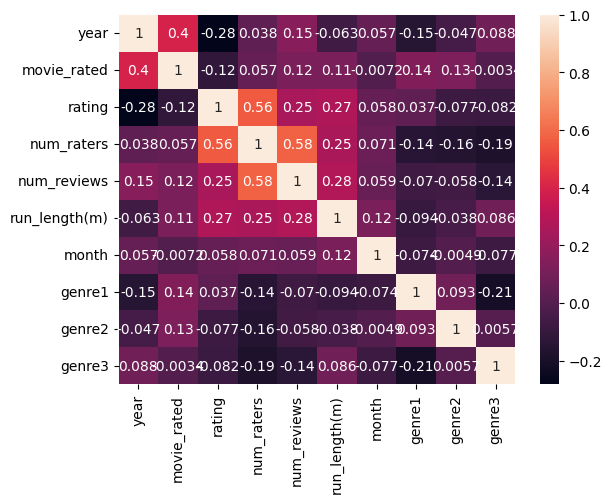

In [5]:
sns.heatmap(df.corr(), annot=True)

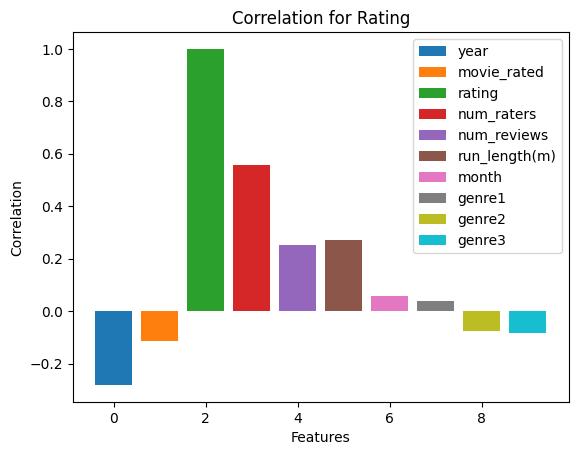

<Figure size 700x700 with 0 Axes>

In [6]:
fig, ax = plt.subplots()
plt.figure(figsize=(7,7))

labels=df.corr().columns

ax.bar(np.arange(len(labels)),df.corr().iloc[:,2], align='center', label=labels, color=sns.color_palette().as_hex())
ax.legend(df.corr().columns)
ax.set_xlabel('Features')
ax.set_ylabel('Correlation')
ax.set_title('Correlation for Rating')
plt.show()


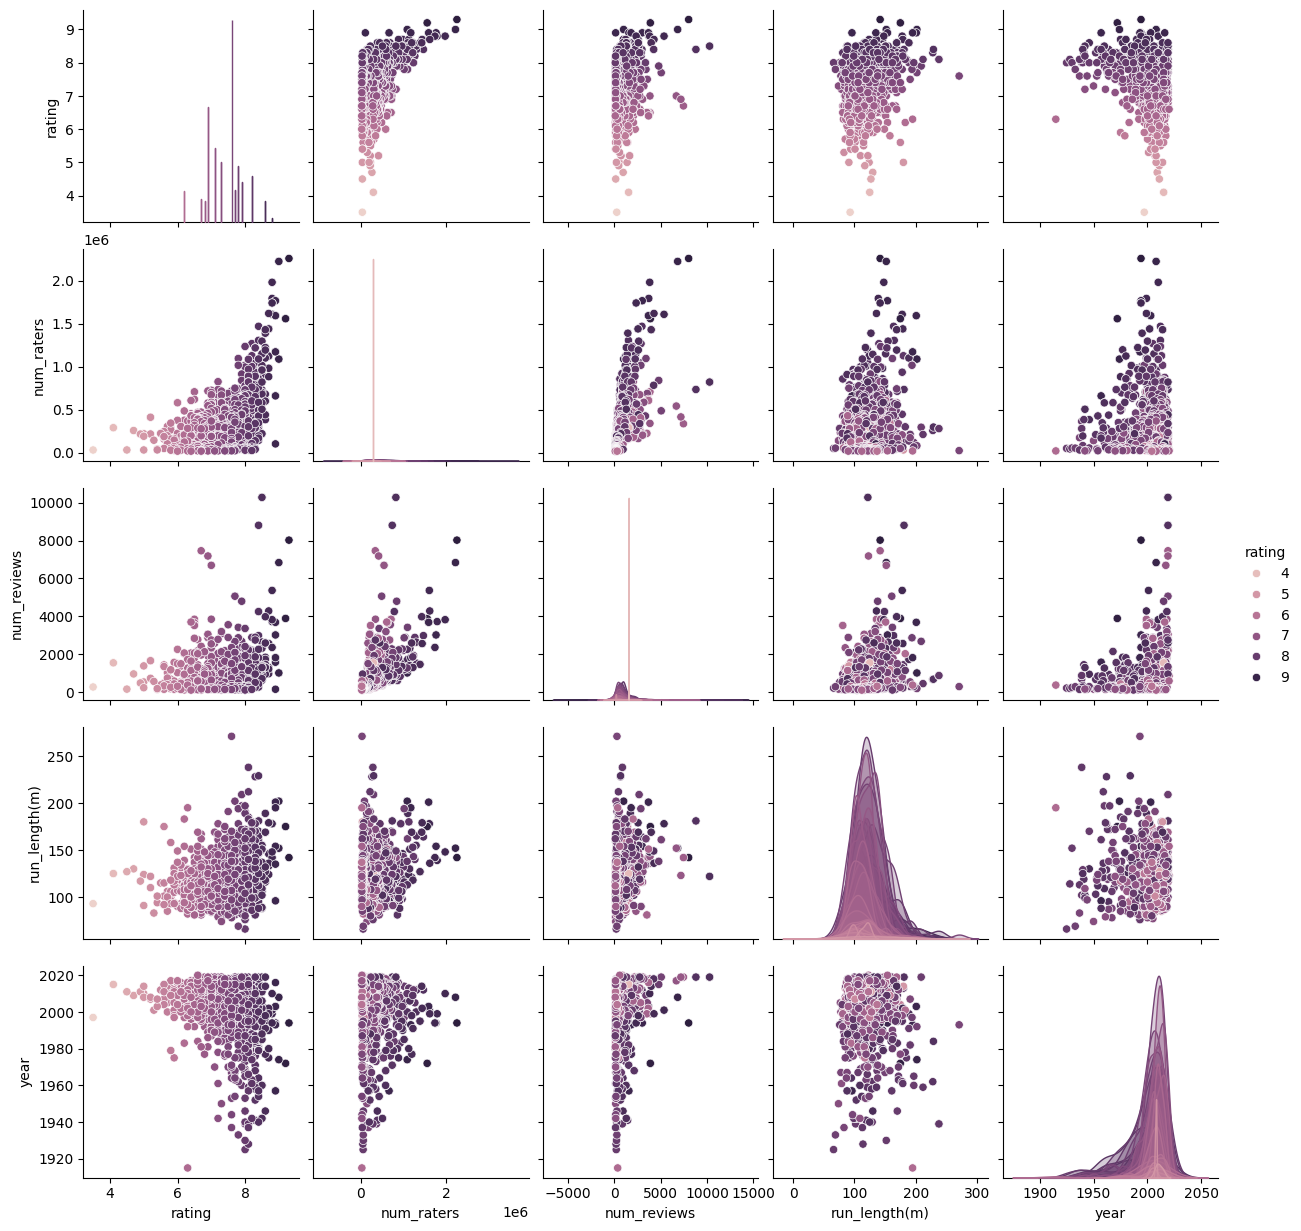

In [7]:
sns.pairplot(data=df,
             x_vars=['rating','num_raters','num_reviews', 'run_length(m)', 'year'],
             y_vars=['rating','num_raters','num_reviews', 'run_length(m)', 'year'],
             hue='rating')

# PCA And Dimensionality Reduction

We try to reduce the dimensionality of the dataset D. However the screeplot relative to the PCA components (The variance explained by each component) clearly show no elbow point making
dimensionality reduction challenging. We choose the value of 3 to visualize the plot correctly.


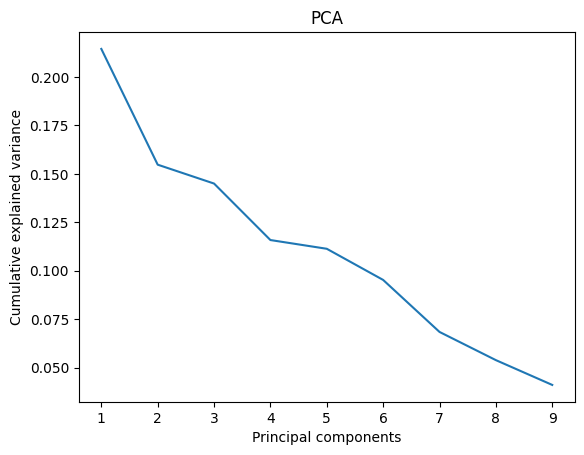

In [32]:
y=df['rating']
#col=['num_raters','num_reviews', 'run_length(m)', 'year', 'num_reviews', 'genre2']
X=df.drop(columns=['rating'])
X=pd.DataFrame(sk.preprocessing.StandardScaler().fit(X).transform(X), columns=X.columns)
A=sk.decomposition.PCA(n_components=None).fit(X)

plt.plot(np.arange(1,10),A.explained_variance_ratio_)
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA')
plt.show()

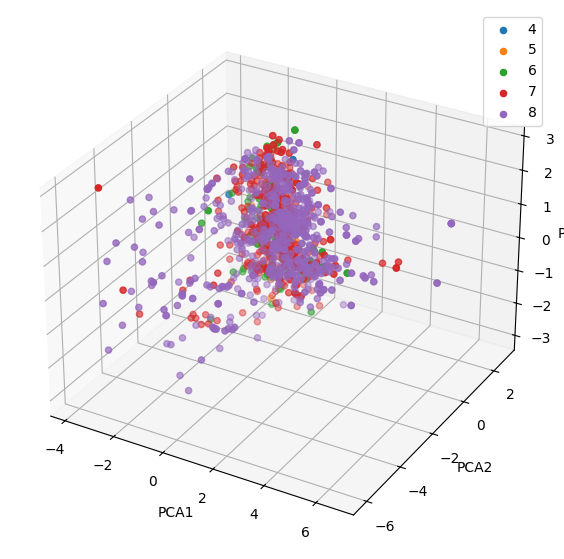

In [9]:
X_pca=pd.DataFrame(sk.decomposition.PCA(n_components=3).fit_transform(X), columns=[1,2,3])
ax = plt.figure(figsize=(7,7)).add_subplot(projection='3d')
X_pca['t']=round(y)

for i in range(4,9):
    ax.scatter(X_pca[1][X_pca['t']==i], X_pca[2][X_pca['t']==i], X_pca[3][X_pca['t']==i], label=i)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.legend()

# KNN technique

We can discretize the labels instead of treating them as continuous  values. Now that we have projected the dataset into our new 3d space, we can try a simple non parametric method for classification. But before we need to test for the optimal k such that the voting process of k points decides the unknow point class. This is 3, but from the 3D plot we can see that data is distributed in non linear pattern that is concentrated around the center cloud. So choosing a small set of point isn't very reasonable, we therefore choose 10.
And the Cross validated (8 fold) accuracy for this method is around 60%.

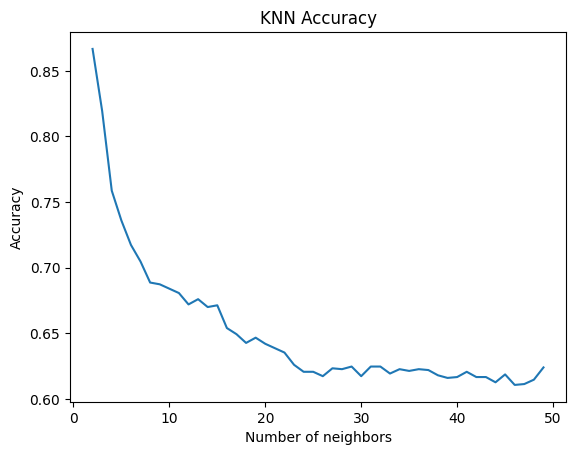

In [10]:
accuracy=[]

for i in range(2,50):
    knn=sk.neighbors.KNeighborsClassifier(n_neighbors=i).fit(X_pca.iloc[:,:3],X_pca['t'])

    acc=sk.metrics.accuracy_score(X_pca['t'],knn.predict(X_pca.iloc[:,:3]))
    accuracy.append(acc)

plt.plot(np.arange(2,50),accuracy)
plt.title('KNN Accuracy')
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [11]:
kf=sk.model_selection.KFold(n_splits=8, shuffle=True)


cross_validated_accuracy=[]
for i, (train_index, test_index) in enumerate(kf.split(X_pca)):
    filtered=X_pca.iloc[train_index,:]
    test=X_pca.iloc[test_index,:]
    knn=sk.neighbors.KNeighborsClassifier(n_neighbors=10).fit(filtered.iloc[:,:3], filtered['t'])
    acc=sk.metrics.accuracy_score(test['t'],knn.predict(test.iloc[:,:3]))
    cross_validated_accuracy.append(acc)

cross_validated_accuracy=np.sum(cross_validated_accuracy)/len(cross_validated_accuracy)
print('Cross validated accuracy: ', round(cross_validated_accuracy,3))




Cross validated accuracy:  0.599


# Linear and Non linear SVC

We perform a randomized search for hyperparameter tuning to fit SVM with linear kernel and non linear kernel. We get a crossvalidated score of 64% for the non linear one and 55% for the linear.

In [12]:


C_dist=loguniform(1e-10, 1e10)
gamma_dist=loguniform(1e-10, 1e10)
svc=sk.svm.SVC(max_iter=5000, kernel='rbf')

random_search=sk.model_selection.RandomizedSearchCV(
    estimator=svc,
    param_distributions={'C':C_dist, 'gamma':gamma_dist},
    n_iter=100, #how many random sample to evaluate from distribution
    n_jobs=-1,
    cv=4,
    verbose=2,
)

random_search.fit(X_pca.iloc[:,:3], X_pca['t'])
print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)


Fitting 4 folds for each of 100 candidates, totalling 400 fits
Best parameters: {'C': 51.35918738114057, 'gamma': 742.6067082090175}
Best CV score: 0.648


In [13]:
C_dist=loguniform(1e-4, 1e4)
svc=sk.svm.LinearSVC(max_iter=5000)

random_search=sk.model_selection.RandomizedSearchCV(
    estimator=svc,
    param_distributions={'C':C_dist},
    n_iter=1000, #how many random sample to evaluate from distribution
    n_jobs=-1,
    cv=4,
    verbose=2,
)
random_search.fit(X_pca.iloc[:,:3], X_pca['t'])
print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)


Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
Best parameters: {'C': 786.4518824208718}
Best CV score: 0.556


# Decision Tree Regressor

Now we aren't treating anymore the problem as a generalized classification task. By treating the problem as a regression we can use the decision tree regressor.A simple yet powerful method for defining a complex tree structure where splits represent decision boundaries that minimize a regression loss function. With this method we achieve a +-0.38 MAE loss. This mean for example that if the rating is 7, based upon current data, the model will predict in average 7.38 or 6.62.

In [177]:
d_y= df['rating']
d_x= df.loc[:, df.columns != 'rating']

losses=[]
for i in range(10):
    clf = sk.tree.DecisionTreeRegressor(criterion='friedman_mse')

    losses.append(-np.mean(sk.model_selection.cross_val_score(clf, d_x, d_y, cv=4,scoring='neg_mean_absolute_error')))
print('cross validated MAE for decision Tree: ',np.mean(losses))


cross validated MAE for decision Tree:  0.38695333333333337


# Deep neural networks and Synthetic Data generation

We're now building DNN. This is done in the hope of getting a better model, also to  capture the non linear relationship the other more simple models couldn't capture. By experimenting with the number of layers i've found that adding to many dense layer to DNN for this specific task makes the performance worse. So we stick with a simple DNN composed by input layer, Dense layer  and a output layer. We choose 50 epoch to train because we don't have much data. The training than lead to 0.37 MAE loss the same with the decision tree regressor. So i decided to investigate the data and found that only 6 points out of 1500 had a rating lower than 5. So the model was clearly biased toward high rating. And would give bad result when looking at low rating films. In fact i've computed the MAE  for these specific 6 points and it was 1.60 noticeably higher than the average test error. Out of those 6 points i've decided to estimate their mean and their covariance matrix to build a Multivariate gaussian that would generate points with low rating. The same process was repeated for finding points with 3.5< rating. For every data augmentation iteration we generated 200 points for a total of 400 synthetic datapoint generated. We choose 400 and not more to keep the presence of real data the majority. This will also give a biased model, but this time  5< rating data points won't be alien for our model. Training again, the approach yield 0.043 MAE, a staggering result. Model now is more precise and only miscalculate an average of +-0.043 from the real rating.


In [182]:
print(X.shape, y.shape)
input_shape=[X.shape[1]]

def model_training(X,y):
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.15)
    X_train, X_validation, y_train, y_validation = sk.model_selection.train_test_split(X_train, y_train, test_size=0.15)


    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=512, activation='relu'),
        tf.keras.layers.Dense(units=1)
    ])
    model.compile(optimizer='adam',
                  loss='mae')



    losses = model.fit(X_train, y_train,
                       validation_data=(X_validation, y_validation),
                       epochs=50,  # total epoch
                       )
    return model, X_test,y_test
model, X_test1, y_test1=model_training(X,y)
    #model.summary()

(1500, 9) (1500,)
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3396 - val_loss: 5.1250
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5095 - val_loss: 1.9602
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3487 - val_loss: 1.0819
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9356 - val_loss: 0.8998
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8240 - val_loss: 0.8269
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7535 - val_loss: 0.7412
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6983 - val_loss: 0.6786
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6544 - val_loss: 0.6212
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6194 - val_loss: 0.5975
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5783 - val_loss: 0.5582
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5542 - val_loss: 0.5271
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - los

In [183]:
prediction=pd.DataFrame( zip(model.predict(X_test1)[:,0], y_test1), columns=['Prediction','True'])
mae=sk.metrics.mean_absolute_error(prediction['True'], prediction['Prediction'])
mse=sk.metrics.mean_squared_error(prediction['True'], prediction['Prediction'])
print(mae,mse)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
0.3722726054721408 0.2786321328795572


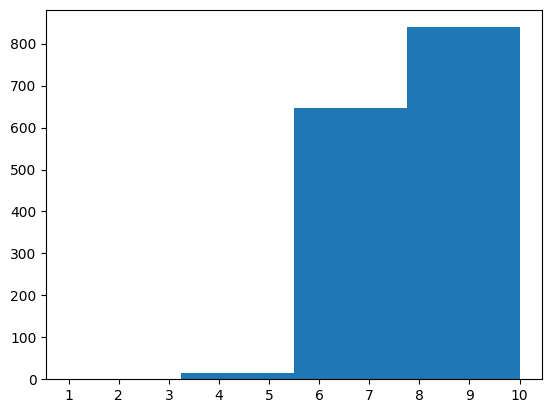

In [16]:
plt.hist(round(df['rating']), range=(1,10), bins=4, align='mid')
plt.xticks(np.arange(1, 11))
plt.show()

In [184]:
y_low=y_test1.iloc[np.where(y_test1<6)]
test_low_score=X_test1.iloc[np.where(y_test1<6)[0]]
p_low=model.predict(test_low_score, verbose=0)
mae_for_low=sk.metrics.mean_absolute_error(p_low[:,0], y_low.to_numpy())
print('MAE error:', mae_for_low)

def data_generation(r, df):
    ind=np.where(df['rating']<r)[0]
    filtered=df.iloc[ind,:]
    mean=filtered.mean()
    var=filtered.cov()
    synthetic_data=np.random.multivariate_normal(mean,var,size=200)

    synthetic_data=pd.DataFrame(synthetic_data,columns=df.columns)
    rating=np.round(synthetic_data['rating'],1)

    synthetic_data=np.round(synthetic_data.loc[:, df.columns != 'rating']).map(int)

    synthetic_data['rating']=rating
    concatenated=pd.concat([synthetic_data,df], ignore_index=True)
    return concatenated
concatenated=data_generation(5,df)
c=data_generation(3.5, concatenated)

MAE error: 1.6037443757057188


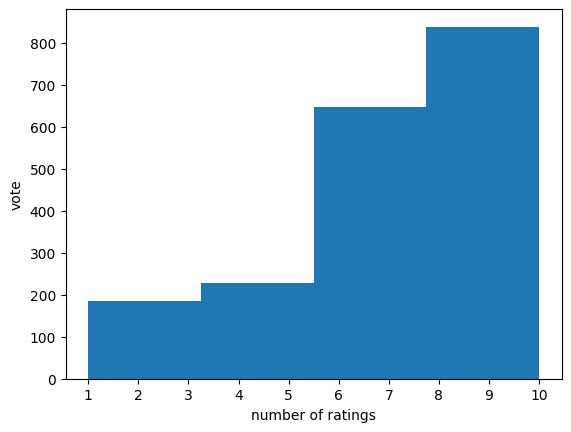

In [18]:

plt.hist(round(c['rating']), range=(1,10), bins=4, align='mid')
plt.xticks(np.arange(1, 11))
plt.xlabel('number of ratings')
plt.ylabel('vote')
plt.show()


In [19]:
c_rating=c['rating']

scaled=pd.DataFrame(sk.preprocessing.StandardScaler().fit_transform(c), columns=df.columns)

scaled.drop(columns=['rating'], inplace=True)
model, X_test, y_test= model_training(scaled, c_rating)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.9116 - val_loss: 3.3659
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9438 - val_loss: 1.0633
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8617 - val_loss: 0.6607
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6379 - val_loss: 0.5348
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5067 - val_loss: 0.4315
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4047 - val_loss: 0.3434
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3177 - val_loss: 0.2665
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2520 - val_loss: 0.2220
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2072 - val_loss: 0.1827
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1554 - val_loss: 0.1407
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1229 - val_loss: 0.1168
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0937 - val_lo

In [20]:
prediction=pd.DataFrame( zip(model.predict(X_test)[:,0], y_test), columns=['Prediction','True'])
mae=sk.metrics.mean_absolute_error(prediction['True'], prediction['Prediction'])
mse=sk.metrics.mean_squared_error(prediction['True'], prediction['Prediction'])
print(mae,mse)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
0.0437872103640908 0.0036703040569589507


# Descriptive Analytics

This section is dedicated to analyzing the dataset. We want to derive some useful information by looking at data.

- The highest rated months are September and December.
- Films are mostly released in October,November,June the number of film released in these three month is 36% of the total films released.
- The average rating per year tends to decrease as time passes. Before the 1975 the average rating for film was 8.02, after 1975 7.6
- The sum of reviews per year increased exponentially from 1995 to 2020, before 1995 there were much less review. This makes possible that a more professional audience was involved into film reviews, that might explain the difference in rating. However there could be more hypothesis such that modern film are less good, or there is too much variety in the option we couldn't know for sure
- The average rating for Genres of films does not vary very much. By plotting the histogram it seem's like a uniform distribution.
- Pie charts are made to display the number of reviewers per Genre. Since the number or reviewers is a strong indicator of how good one film is, we can assume that the more review a genre has, the more it's generally liked by the public. This is not always True, but can serve as a useful metric.
- For the first film genre pie chart: Action, Comedy and Drama represent around 46% of the review pool
- For the second film genre: Drama and Adventure are leaders, which aggregated form around 55% of the review pool
- For the third film genre: Thriller,Scifi, Drama >50% of the review pool

Suggestion based on data is to publish film in October, November or December. The preferred genre combination are: [Action, Drama] , [Comedy, Adventure], [Action, Adventure], [Action, Drama, Thriller], [Comedy, Adventure, Scifi], [Action,Adventure, Scifi]


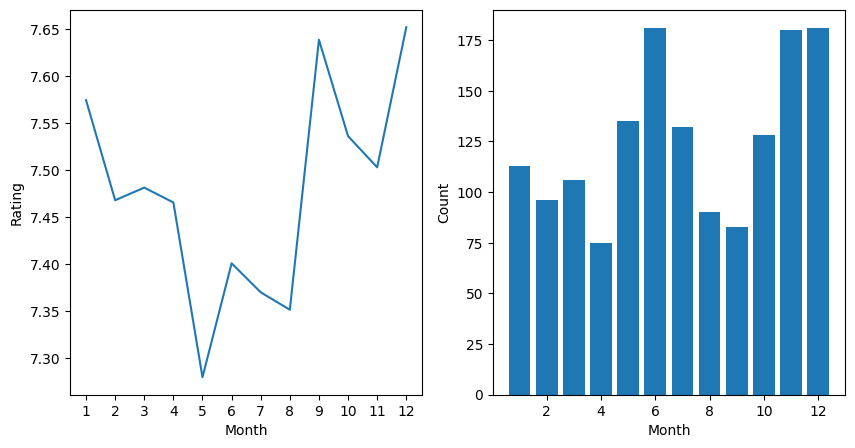

0.36


In [189]:
grouped=df.groupby(['month']).mean()
count=df.groupby(['month']).count().iloc[:,0]

fig, (ax1, ax2)= plt.subplots(1,2, figsize=(10,5))
ax1.plot(np.arange(1,13), grouped['rating'])
ax2.bar(np.arange(1,13),count)
ax1.set_xlabel('Month')
ax1.set_ylabel('Rating')
ax2.set_ylabel('Count')
ax2.set_xlabel('Month')
ax1.set_xticks(np.arange(1, 13))
plt.show()
print( round((count[6]+count[11]+count[12])/np.sum(count),2))

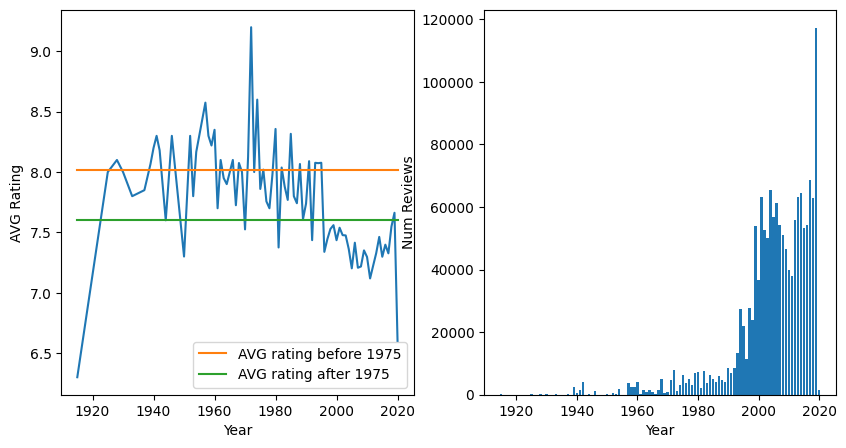

In [209]:
grouped=df.groupby(['year']).mean()
population=df.groupby(['year']).sum()
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(10,5))


first_line=[np.mean(grouped['rating'].iloc[np.where(grouped.index < 1975)] ) for x in range(len(grouped.index))]
second_line=[np.mean(grouped['rating'].iloc[np.where(grouped.index >= 1975)] ) for x in range(len(grouped.index))]

ax1.plot(grouped.index, grouped['rating'])
ax1.plot(grouped.index,first_line, label='AVG rating before 1975')
ax1.plot(grouped.index,second_line, label='AVG rating after 1975')

ax2.bar(population.index, population['num_reviews'])
ax1.set_xlabel('Year')
ax1.set_ylabel('AVG Rating')
ax2.set_xlabel('Year')
ax2.set_ylabel('Num Reviews')
ax1.legend()
plt.show()

Text(0.5, 1.0, 'Average Rating per Genre')

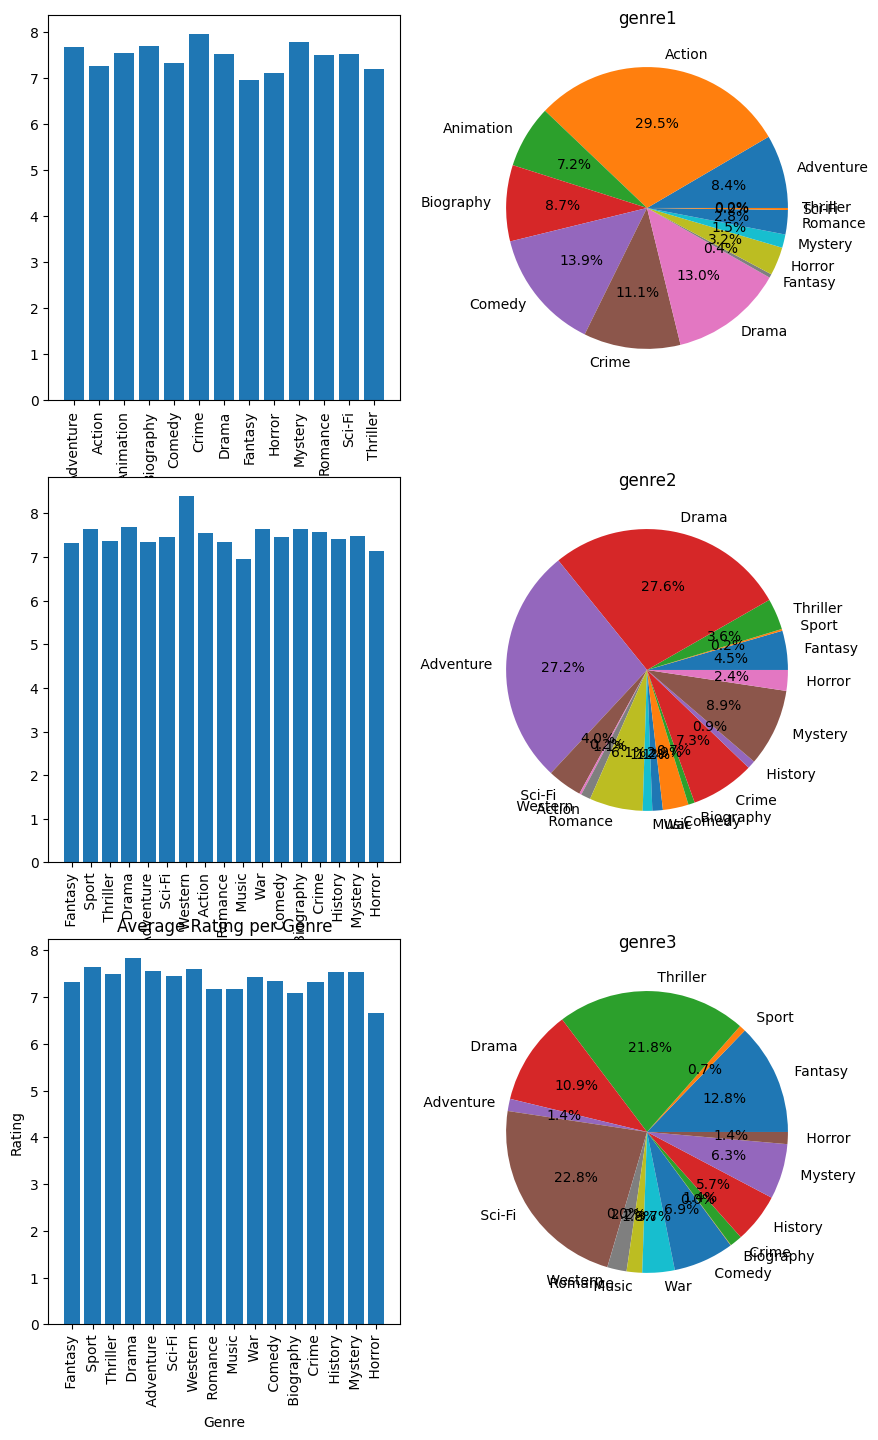

In [23]:
def func(df,genre):

    grouped=df[df[genre] != 0].groupby(genre)['rating'].agg(lambda x: x.mean())
    population=df[df[genre] != 0].groupby(genre)['num_raters'].agg(lambda x: x.sum())
    key_dictionary={key:item for item, key in genre_dictionary.items()}
    key_dictionary[0]='Null'
    def trad(x,key_dictionary):
        return key_dictionary[x]
    idx=[trad(x, key_dictionary) for x in grouped.index]
    return idx, grouped, population

genres=['genre1', 'genre2', 'genre3']
fig, axes= plt.subplots(3,2, figsize=(10,17))

for i,(ax1,ax2) in enumerate(axes):
    idx, grouped, population = func(df, genres[i])

    ax1.bar(idx, grouped)
    ax1.tick_params(axis='x', rotation=90, labelbottom=True)
    ax2.pie(population, labels=idx, autopct='%1.1f%%')
    ax2.set_title(genres[i])


ax1.tick_params(axis='x', rotation=90, labelbottom=True)

ax1.set_xlabel('Genre')
ax1.set_ylabel('Rating')

ax1.set_title('Average Rating per Genre')